# How to define a compartment population model in Compartor  
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\def\Yc{\mathbf{Y}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$

Whenever using Compartor in a Jupyter notebook, run the following commands:

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
from compartor import *

## Usage of the constructor TransitionClass

The population dynamics are specified in Compartor through a set of transition classes. These are stoichiometric-like equations whose left-hand and right-hand sides specify how some `Compartments` are modified by the occurrence of a transition.

To define a compartment $[\x]$, it is first necessary to define some `Content` variables $\x \in \N_0^D$ that Compartor can interpret as symbols on which to perform symbolic computation. For instance,

In [2]:
x = Content('x')
y = Content('y')
Compartment(x)

Content variables are $D$-dimensional, with `x[d]` denoting the copy number of chemical species `d`, for $d=0,1,...,D-1$ .

Once some content variables have been defined, the fastest way to define a transition class is the constructor `TransitionClass`. For instance,


In [3]:
Exit = TransitionClass( [x] -to> {}, 'k_E', name='E')
display(Exit)

defines a transition class that randomly removes one compartment from the population with rate $k_E$. In particular:

* The first argument of `TransitionClass` is the compartment stoichiometry, where lelf-hand side and right-hand side are separated by the keyword `-to>`. The notation `[x]` denotes a compartment of content `x`, while `{}` denotes the empty set.
* The second argument assignes a name to the rate constant 
* The optional parameter `name` defines the subscript of the transition propensity

Similarly, we can define a transition class that randomly fuses two compartments as follows

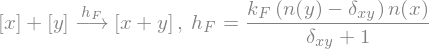

In [4]:
Fusion  = TransitionClass( [x] + [y] -to> [x+y], 'k_F', name='F')
display(Fusion)

Note that the population dependency of the propensity `h` is automatically inferred with the law of mass action. 

Note that in the compartment notation we can use compound expressions inside compartment brackets. In the above example, we have used `x+y` to denote the content formed by adding content vectors `x` and `y`.
Content vectors can be also notated explicitly as $D$-tuples, listing the copy number of each chemical species $d=0,1,...,D-1$.
For example, in the expression `[x + (-1, 0)]`, the tuple `(-1, 0)` denotes a change by $-1$ in chemical species $d=0$ (in a model with $D=2$ species). The expression could be equivalently written as `[(x[0]-1,x[1])]`. We will see more examples of this notation below.

### Propensities with content dependency
It is possible to tune the propensity as a function of the compartment contents by providing a third argument to `TransitionClass`, such as for the following chemical events given in the example of the paper:

In [5]:
Conversion  = TransitionClass( [x] -to> [x + (-1,1)], 'k_c', x[0], name='c')
Degradation = TransitionClass( [x] -to> [x + (0,-1)], 'k_d', x[1], name='d')
display(Conversion, Degradation)

The Conversion class transforms the first chemical species (indexed by `0`) to the second type with propensity $k_cx_0$ in any compartment across the population. The Degradation class, instead, removes one molecule of the second chemical species with rate $k_dx_1$, for a given compartment.

Some transition classes involve compartments on the product side (i.e. right-hand side) whose content is drawn in probabilistic fashion with respect to the reactant compartments. In such cases, a conditional distribution can be passed as optional argument `pi` in `TransitionClass`. 

The type of $\pi$ is `OutcomeDistribution`, which is a class comprising
* an expression or symbol to use for displaying $\pi$ in compound expressions
* a function `expectation` that takes an expression over reactant contents, and returns its expectation over all product compartment variables.

There are generators for several predefined outcome distributions. If nothing is specified, as in the above "Exit" transition example, `OutcomeDistribution.Identity()` is used by default. Instead, when the content of product compartments follows a distribution, other generators can be used or created.

Compartor currently includes the following `OutcomeDistribution` generators
* `Poisson()` 
* `NegativeBinomial()` 
* `Uniform()` 

For example, the model in the paper has an "Intake" transition class where new compartments are created with Poisson-distributed content

In [6]:
from sympy import Symbol
pi_I = OutcomeDistribution.Poisson(Symbol('\pi_{I}(y; \lambda)'),y[0],Symbol('\lambda'))

Intake = TransitionClass( {} -to> [(y[0],0)], 'k_I', pi=pi_I, name='I')
display(Intake)

## Model definition
The declaration of a model consists in defining a list of transition classes. We provide some examples of model declaration here below.

### Example: case study shown in the paper

In [7]:
x = Content('x')
y = Content('y')

# Intake Distribution
pi_I = OutcomeDistribution.Poisson(Symbol('\pi_{I}(y; \lambda)'),y[0],Symbol('\lambda'))


Intake      = TransitionClass( {}        -to> [(y[0],0)],   'k_I', pi=pi_I, name='I')
Fusion      = TransitionClass( [x] + [y] -to> [x+y],        'k_F',          name='F')
Conversion  = TransitionClass( [x]       -to> [x + (-1,1)], 'k_c', x[0],    name='c')
Degradation = TransitionClass( [x]       -to> [x + (0,-1)], 'k_d', x[1],    name='d')

transitions = [ Intake, Fusion, Conversion, Degradation]

The transition classes stored into the variable `transitions` can be displayed with the function `display_transition_classes()` as follows

In [8]:
display_transition_classes(transitions)

Display.__str__: TODO

### Example: nested birth-death process

In [9]:
x = Content('x')
y = Content('y')

# Intake
pi_I = OutcomeDistribution.NegativeBinomial(Symbol('\pi_{NB}(y; \lambda)'), y[0],Symbol('r'),Symbol('p'))

Intake = TransitionClass( {}  -to> [y],   'k_I', pi=pi_I, name='I')
Exit   = TransitionClass( [x] -to> {},    'k_E',          name='E')
Birth  = TransitionClass( [x] -to> [x+1], 'k_b',          name='b')
Death  = TransitionClass( [x] -to> [x-1], 'k_d', x[0],    name='d')

transitions = [Intake, Exit, Birth, Death]
display_transition_classes(transitions)

Display.__str__: TODO

### Example: coagulation-fragmentation system with intake and export

In [10]:
x = Content('x')
y = Content('y')

pi_I = OutcomeDistribution.Poisson(Symbol("\pi_{Poiss}(y; \lambda)"), y[0], Symbol("\lambda"))
pi_F = OutcomeDistribution.Uniform(Symbol("\pi_F(y|x)"), y[0], 0, x[0])

Intake        = TransitionClass( {}        -to> [y],         'k_I',         pi=pi_I, name='I')
Exit          = TransitionClass( [x]       -to> {},          'k_E',                  name='E')
Coagulation   = TransitionClass( [x] + [y] -to> [x+y],       'k_C',                  name='C')
Fragmentation = TransitionClass( [x]       -to> [y] + [x-y], 'k_F', g=x[0], pi=pi_F, name='F')

transitions = [Intake, Exit, Coagulation, Fragmentation]
display_transition_classes(transitions)

Display.__str__: TODO